# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias_copy = deepcopy(azdias)

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(np.shape(azdias))
print(np.shape(feat_info))
azdias.head()

(891221, 85)
(85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


**Use `azdias.describe()`, I found that many columns have naturally missing data (`count`<891211), such as the last few columns. The original azdias data has 85 columns, but the description table has only 81 columns.**

In [6]:
# get missing_or_unknown dict
def get_dict(feat_info):
    missing_unknown_dict = {}
    for attr, miss in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if len(miss) == 2:
            missing_unknown_dict[attr] = ''
        else:
            miss = miss[1:-1].split(',')
            miss_tmp = []
            for m in miss:
                tmp = 0
                try:
                    tmp = int(m)
                except:
                    tmp = m
                miss_tmp.append(tmp)
            missing_unknown_dict[attr] = miss_tmp
    return missing_unknown_dict
            
# Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value
def set_nan(azdias, missing_unknown_dict):
    for key in missing_unknown_dict:
        if missing_unknown_dict[key] == '':
            continue
        else:
            for val in missing_unknown_dict[key]:
                azdias[key].replace(val, np.NaN, inplace = True)
    return azdias

missing_unknown_dict = get_dict(feat_info)
azdias = set_nan(azdias, missing_unknown_dict)
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def count_miss(azdias):
    num_NaN = []
    num_NaN_dict = {}
    cols = azdias.columns
    for col in cols:
        azdias_null_count = azdias[col].isnull().sum()
        num_NaN.append(azdias_null_count)
        num_NaN_dict[col] = azdias_null_count
    return cols, num_NaN, num_NaN_dict
# To see how many naturally missing data in the dataset
cols, num_naturally_missing, num_naturally_missing_dict = count_miss(azdias_copy)
# To see how many NaNs in the dataset
cols, num_NaN, num_NaN_dict = count_miss(azdias)

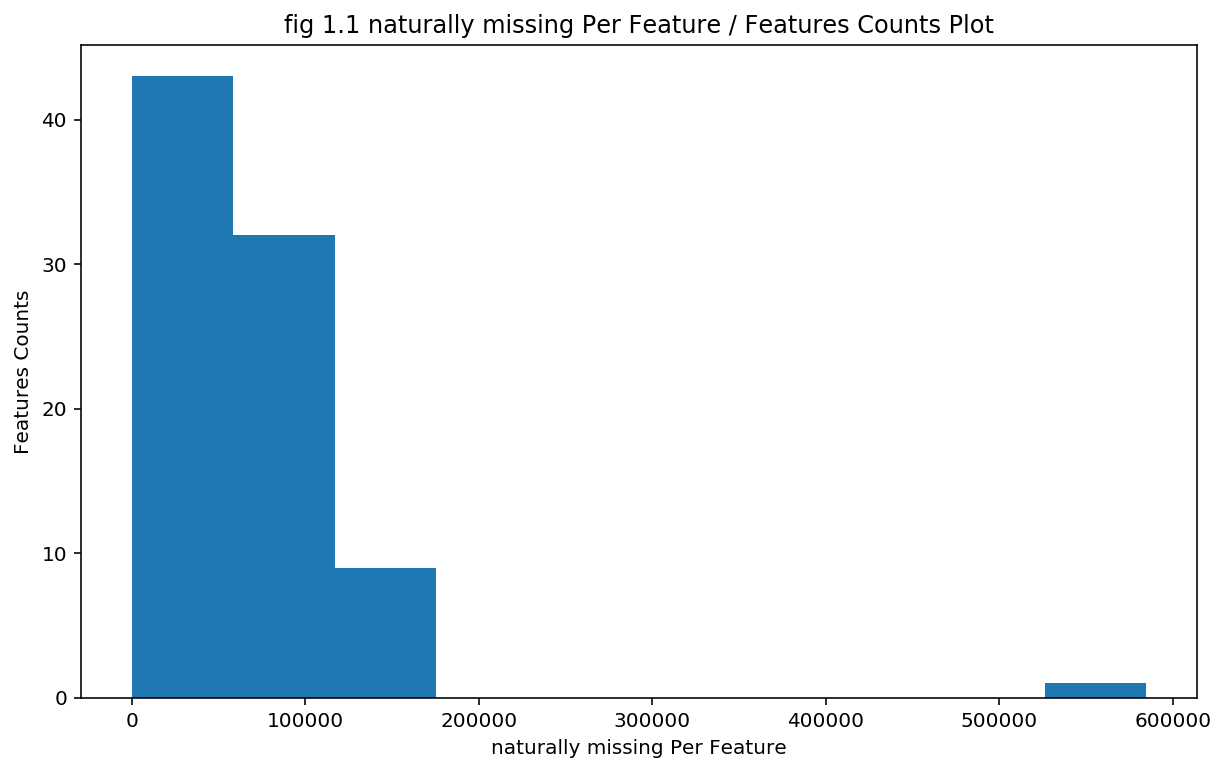

In [8]:
# Investigate patterns in the amount of missing data in each column.
# naturally missing data
plt.figure(figsize = (10,6))
plt.hist(num_naturally_missing)
plt.xlabel('naturally missing Per Feature')
plt.ylabel('Features Counts')
plt.title('fig 1.1 naturally missing Per Feature / Features Counts Plot')
plt.show()

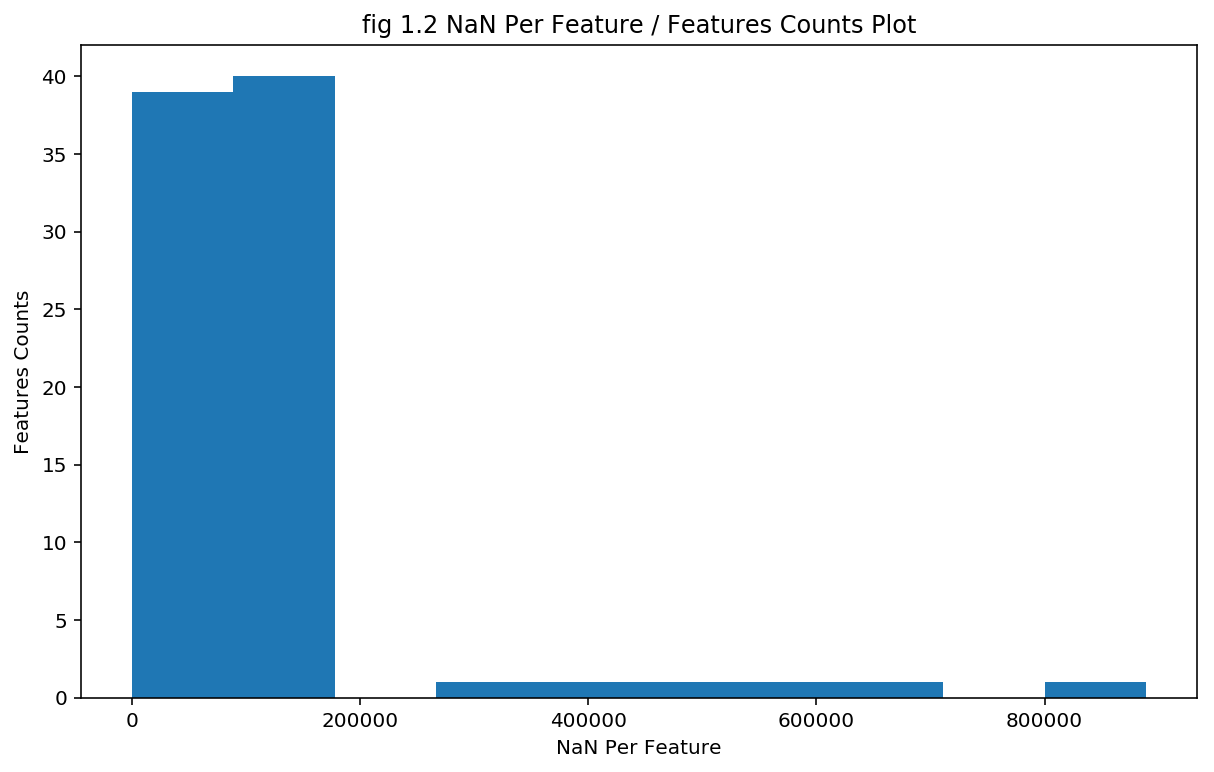

In [9]:
# NaNs data after convert missing value codes to NaNs
plt.figure(figsize = (10,6))
plt.hist(num_NaN)
plt.xlabel('NaN Per Feature')
plt.ylabel('Features Counts')
plt.title('fig 1.2 NaN Per Feature / Features Counts Plot')
plt.show()

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# get drop features list (above 200000 missing values)
num_outlier_column = 0
outlier_column = []
for col in cols:
    if num_NaN_dict[col] > 200000:
        num_outlier_column += 1
        outlier_column.append(col)
print('number of outlier columns:', num_outlier_column)
print('outlier columns:', outlier_column)

number of outlier columns: 6
outlier columns: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [11]:
azdias.drop(outlier_column, axis=1, inplace=True)

In [12]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

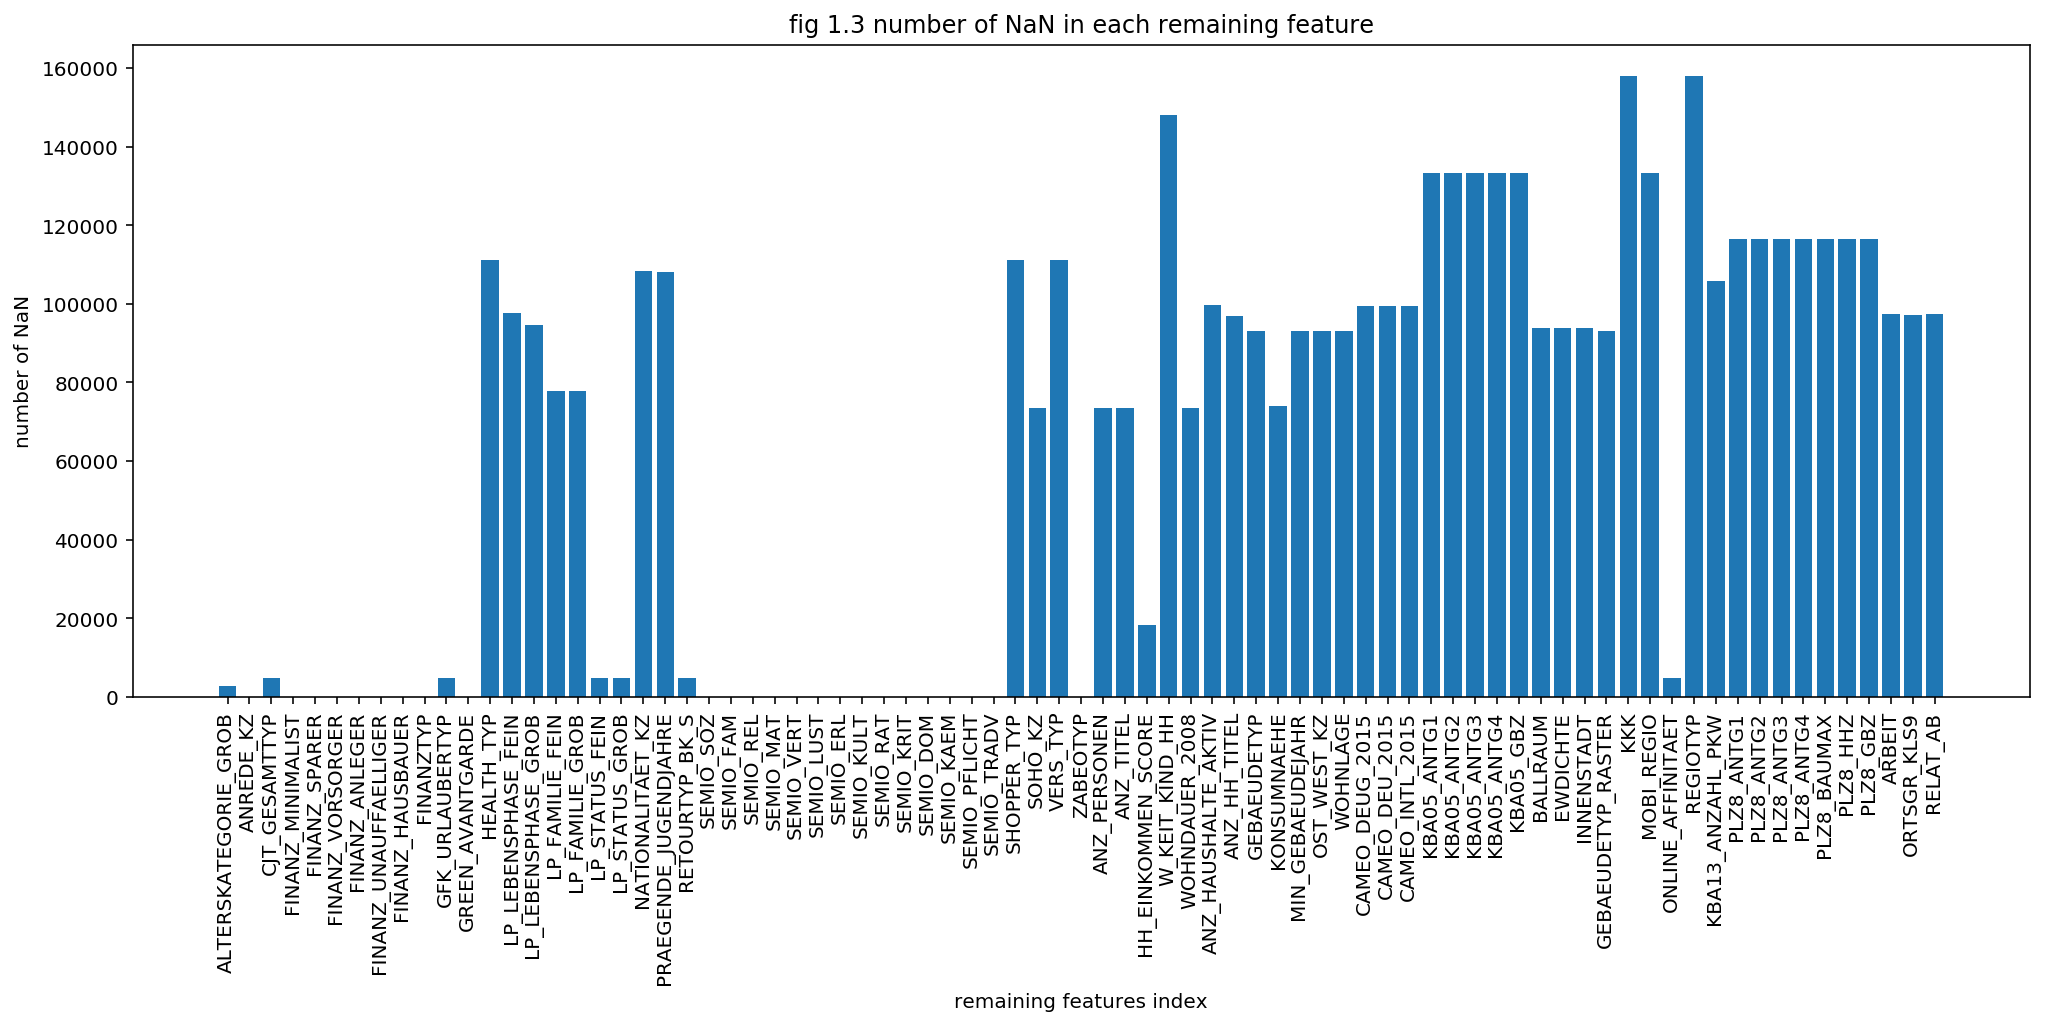

In [14]:
remaining_features = azdias.columns
remaining_num_NaN = []
remaining_num_NaN_dict = {}
for f in remaining_features:
    remaining_num_NaN.append(num_NaN_dict[f])
    remaining_num_NaN_dict[f] = num_NaN_dict[f]


plt.figure(figsize = (17,6))
plt.bar(range(len(remaining_features)), remaining_num_NaN, tick_label=remaining_features)
# plt.bar([str(i) for i in range(len(remaining_features))], remaining_num_NaN)
plt.xlabel('remaining features index')
plt.ylabel('number of NaN')
plt.title('fig 1.3 number of NaN in each remaining feature')
plt.xticks(rotation=90)
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

- If it is evaluated by a strict standards, I think the data missing of the dataset is serious. For the original dataset, in a total of 85 columns, only 32 columns have no naturally missing data. After data that matches a 'missing' or 'unknown' value code was convert into a numpy NaN value, only 24 columns do not contain NaN.
- If I remove all columns that contain missing values, I will lose too many features. I used matplotlib's hist() function to visualize the distribution of missing value counts to find these columns. For most of columns, the number of NaN values is below 200000. So the columns with the number of NaN values greater than 200000 were treated as outlier columns and were removed from the dataset. They are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'.
- According to `azdias.info()` and fig 1.3, I found that the number of missing values in some series of features is exactly equal. The number of missing values of 'KBA05_ANTG1' to 'KBA05_ANTG4' are all 133324. And for 'PLZ8_...', the numbers are all 116515. It seems that there is some kind of pattern in missing values. Because I didn't know if these features have different meanings, I would keep them for the time being.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

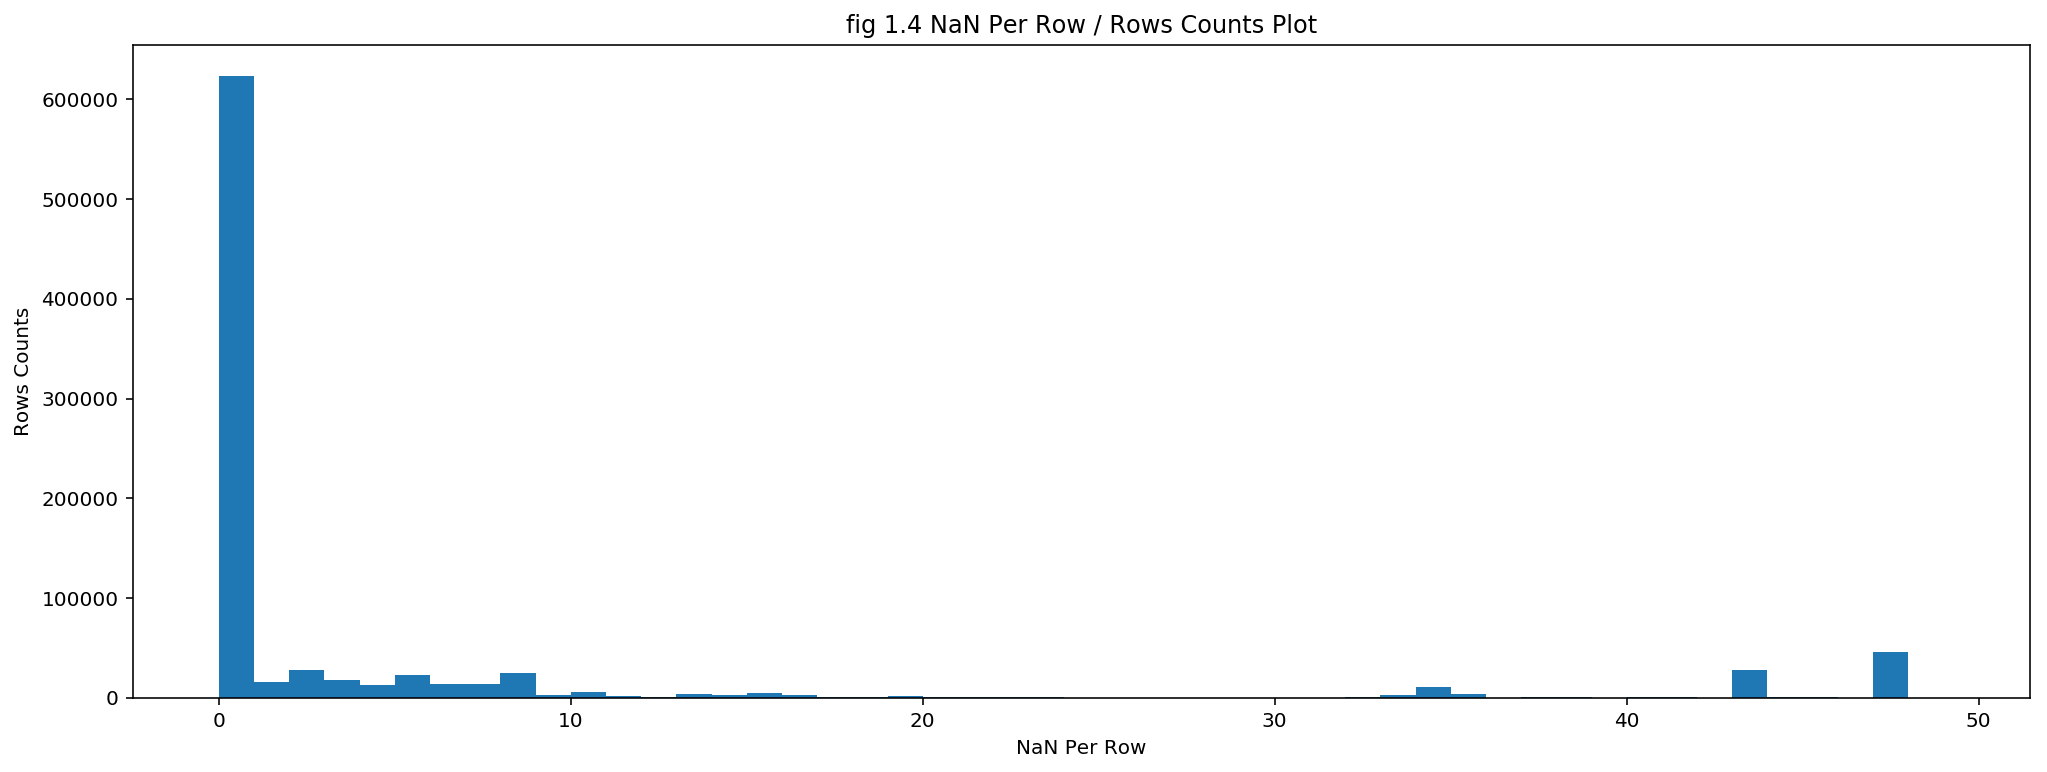

In [15]:
# How much data is missing in each row of the dataset?
num_remaining_features = azdias.shape[1]
num_nan_row = num_remaining_features - azdias.count(axis=1)


plt.figure(figsize = (17,6))
plt.hist(num_nan_row, bins=range(50))
plt.xlabel('NaN Per Row')
plt.ylabel('Rows Counts')
plt.title('fig 1.4 NaN Per Row / Rows Counts Plot')
plt.show()

The distribution of the number of missing values in each row is shown in Figure 1.4. I use 9 as a threshold to divide the dataset.

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
df_nan_less = azdias[azdias.index.isin(num_nan_row[num_nan_row < 9].index)].copy()
df_nan_more = azdias[azdias.index.isin(num_nan_row[num_nan_row >= 9].index)].copy()

**We have about 900,000 rows of data. I think that if the number of missing data in a column is less than 0.1% of the total, then the data in this column is relatively complete. I don't know if this standard is appropriate.**

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# choose the columns where there is no missing value as select_columns_dict
select_columns_dict = {}
for key, val in remaining_num_NaN_dict.items():
    if val < 900:
        select_columns_dict[key] = val
print(select_columns_dict)
print(len(select_columns_dict))

{'ANREDE_KZ': 0, 'FINANZ_MINIMALIST': 0, 'FINANZ_SPARER': 0, 'FINANZ_VORSORGER': 0, 'FINANZ_ANLEGER': 0, 'FINANZ_UNAUFFAELLIGER': 0, 'FINANZ_HAUSBAUER': 0, 'FINANZTYP': 0, 'GREEN_AVANTGARDE': 0, 'SEMIO_SOZ': 0, 'SEMIO_FAM': 0, 'SEMIO_REL': 0, 'SEMIO_MAT': 0, 'SEMIO_VERT': 0, 'SEMIO_LUST': 0, 'SEMIO_ERL': 0, 'SEMIO_KULT': 0, 'SEMIO_RAT': 0, 'SEMIO_KRIT': 0, 'SEMIO_DOM': 0, 'SEMIO_KAEM': 0, 'SEMIO_PFLICHT': 0, 'SEMIO_TRADV': 0, 'ZABEOTYP': 0}
24


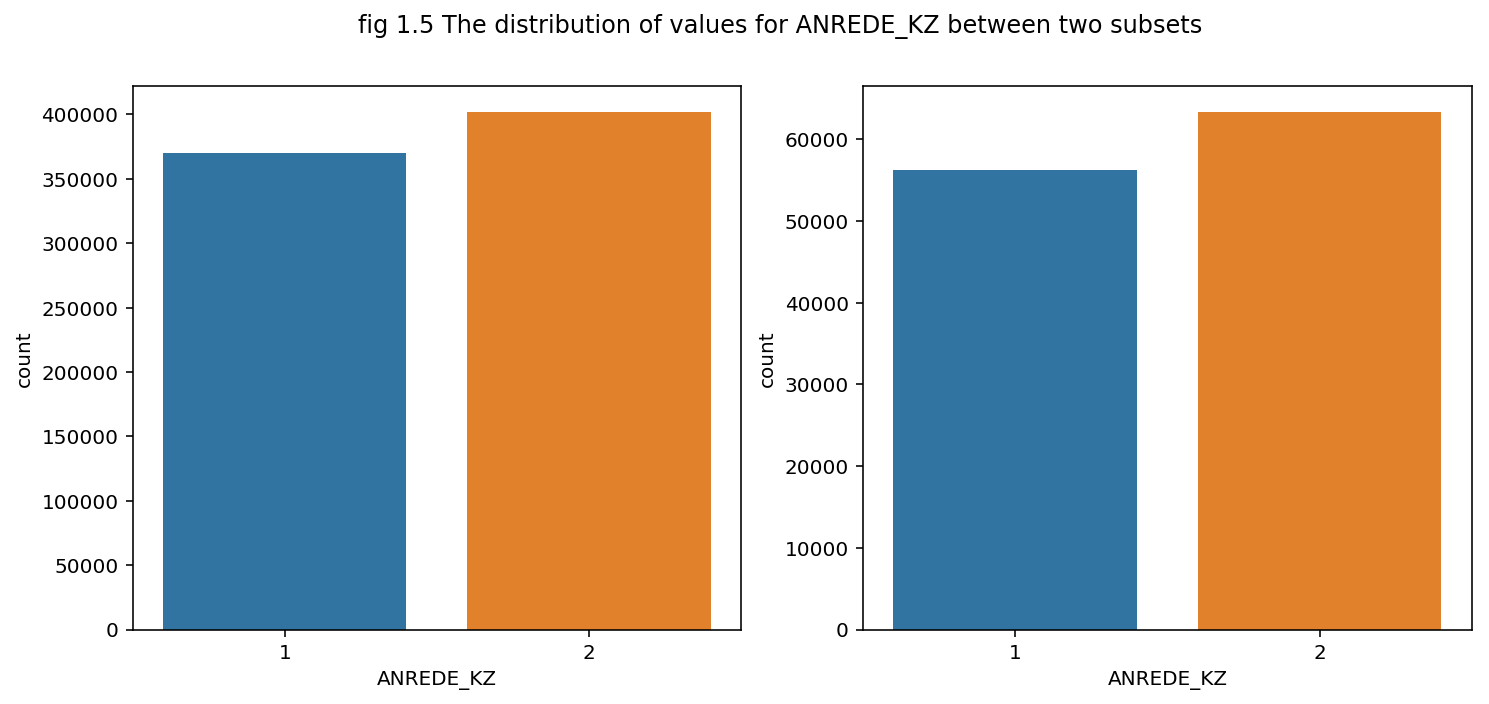

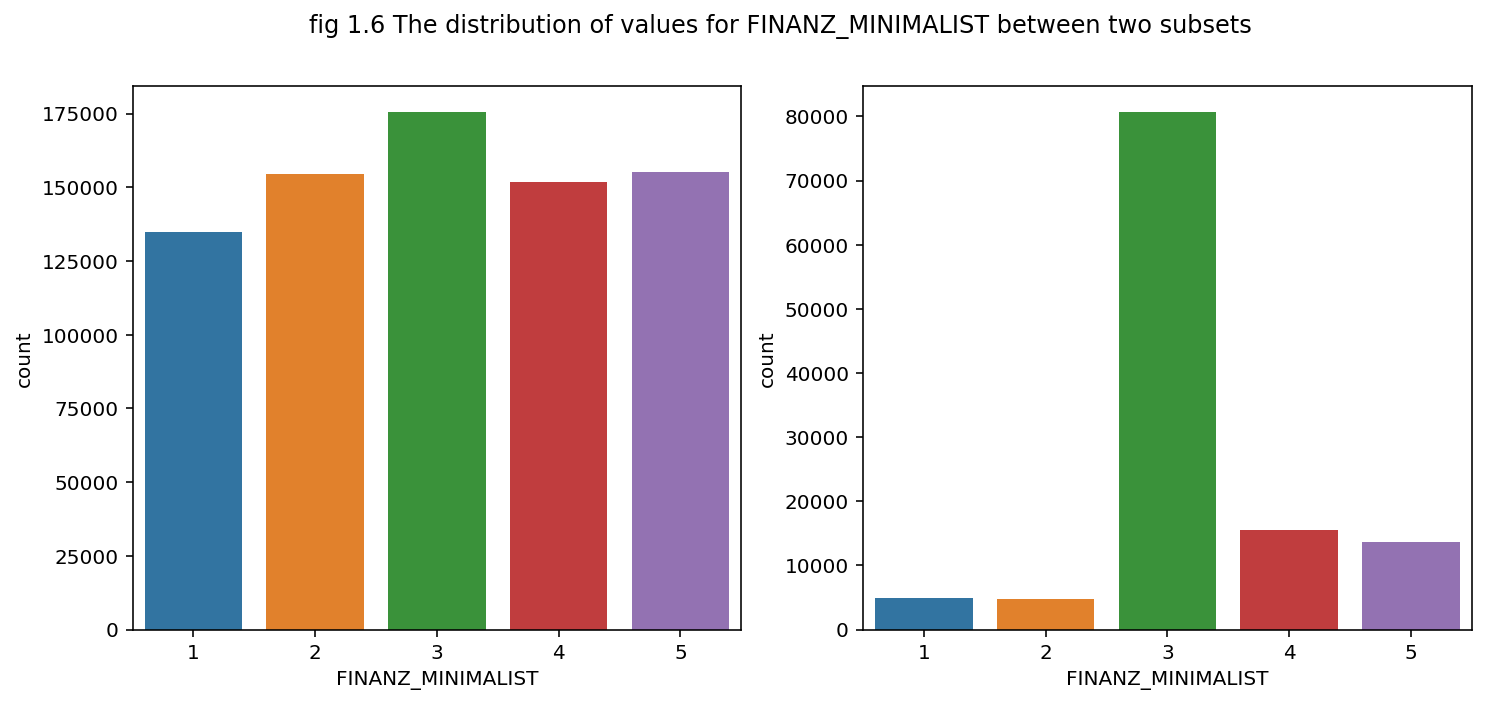

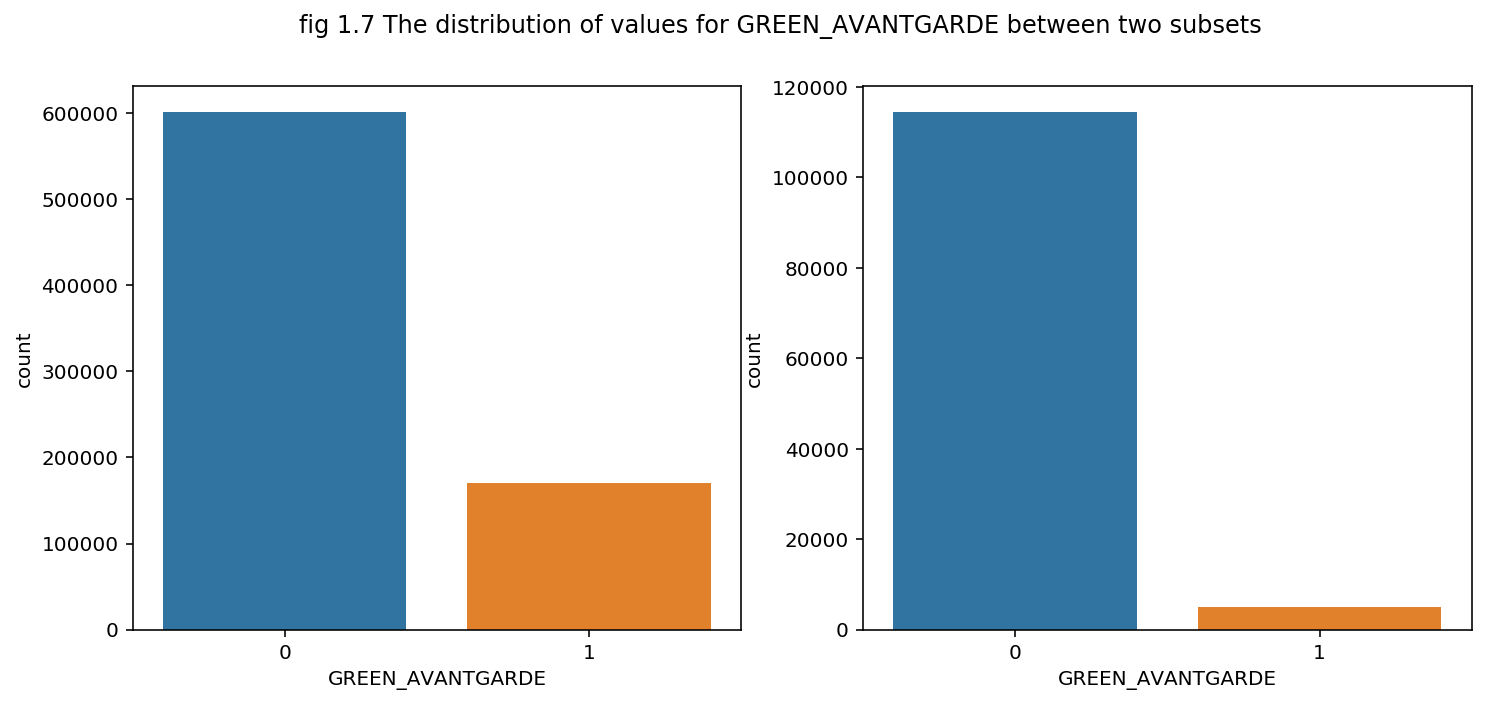

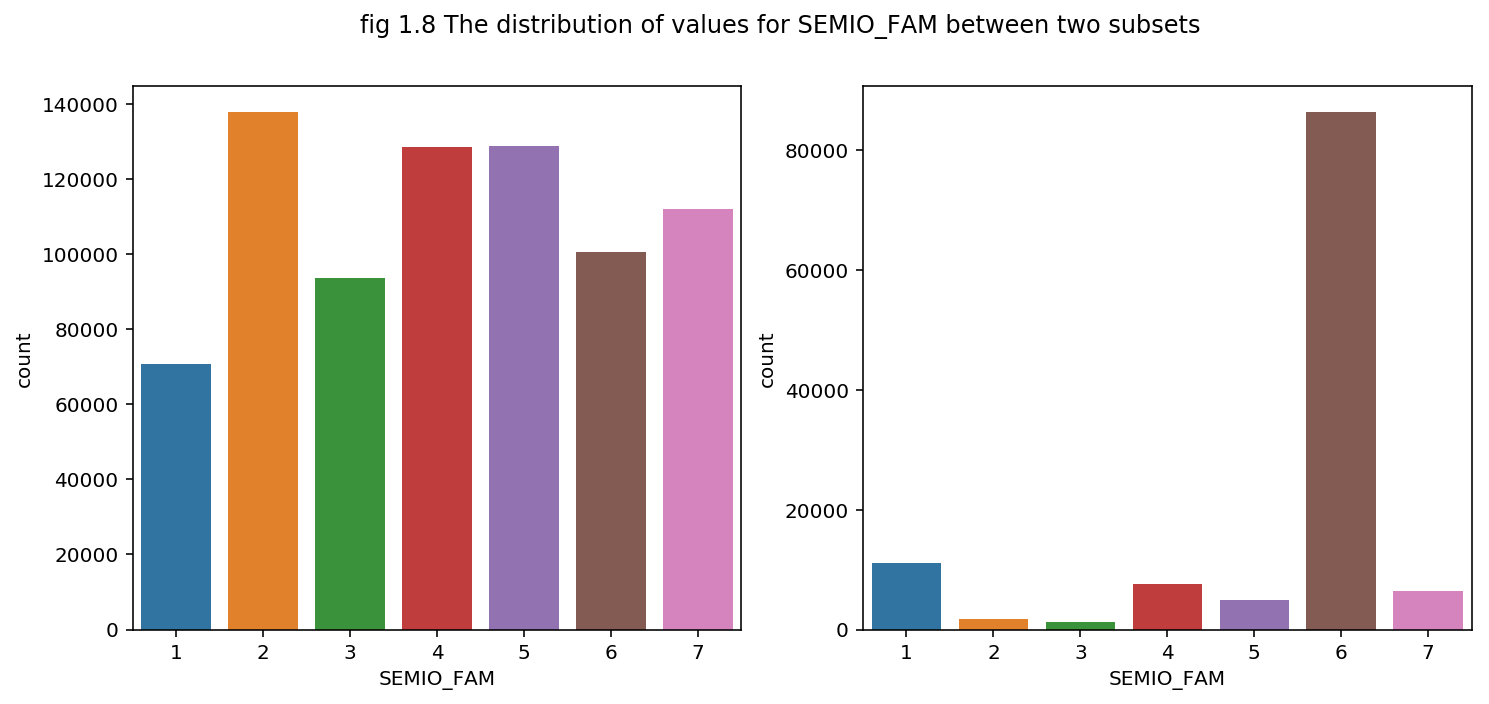

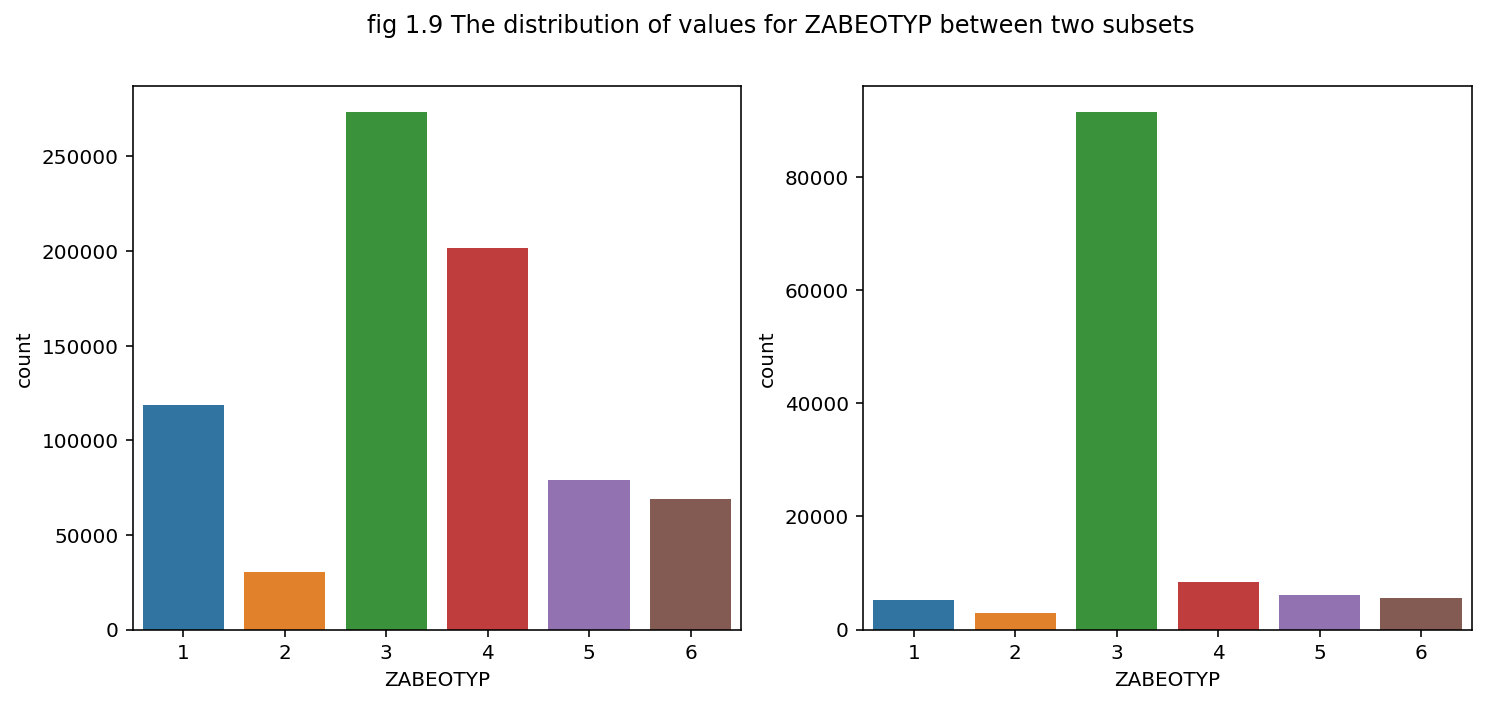

In [18]:
# choose columns:'ANREDE_KZ', 'FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'SEMIO_FAM', 'ZABEOTYP'
select_columns = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'SEMIO_FAM', 'ZABEOTYP']
def show_distribution(subset1, subset2, features):
    len_features = len(features)
    for i in range(len_features):
        plt.figure(i+1, figsize = (12, 5))
        plt.subplot(1, 2, 1)
        sns.countplot(x= features[i], data=subset1)
        plt.subplot(1, 2, 2)
        sns.countplot(x= features[i], data=subset2)
        plt.suptitle('fig 1.' + str(i + 5) + ' The distribution of values for '+features[i]+' between two subsets')
    
    
show_distribution(df_nan_less, df_nan_more, select_columns)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- By observing the distribution of the number of missing values in each row, I chose 9 as the threshold to divide the data set. Because there is a mutation in the number of 9.
- I wrote a function to find the columns where there are no missing values, and got 24 columns. In these columns, I picked up five features that looked different in meaning by name. They are 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'SEMIO_FAM' and 'ZABEOTYP'.
- The distribution of values between the two subsetsdata was shown in fig 1.5 to 1.9.In my opinion, only the distributions of the 'ANREDE_KZ' look similar. For the other four features,the data with many missing values looks very different from the data with no missing values. Maybe simply dropping those points from the analysis will present some issues.
- According to the guidance, I would continue my analysis using the subset of the data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
count_type_dict = {}
for types in feat_info['type']:
    try:
        count_type_dict[types] += 1
    except:
        count_type_dict[types] = 1
print(count_type_dict)

{'categorical': 21, 'ordinal': 49, 'numeric': 7, 'mixed': 7, 'interval': 1}


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# get the list of features with categorical data
categorical_features_list = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
# if the feature has been dropped, delete it from the list
for feature in categorical_features_list:
    if feature not in df_nan_less.columns:
        categorical_features_list.remove(feature)
print(categorical_features_list)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [21]:
drop_list = ['LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
categorical_features_list.remove('LP_FAMILIE_FEIN')
categorical_features_list.remove('LP_STATUS_FEIN')
df_nan_less.drop(drop_list, axis=1, inplace=True)

In [22]:
# judge categorical is binary or multi-level
binary_categoricals_dict = {}
multi_level_categoricals_dict = {}
for feature in categorical_features_list:
    categories = list(set(list(df_nan_less[df_nan_less[feature].notnull()][feature])))
    if len(categories) == 2:
        binary_categoricals_dict[feature] = categories
    else:
        multi_level_categoricals_dict[feature] = categories
print('binary_categoricals_dict:\n', binary_categoricals_dict)
print('multi_level_categoricals_dict:\n', multi_level_categoricals_dict)

binary_categoricals_dict:
 {'ANREDE_KZ': [1, 2], 'GREEN_AVANTGARDE': [0, 1], 'SOHO_KZ': [0.0, 1.0], 'VERS_TYP': [1.0, 2.0], 'OST_WEST_KZ': ['O', 'W']}
multi_level_categoricals_dict:
 {'CJT_GESAMTTYP': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 'FINANZTYP': [1, 2, 3, 4, 5, 6], 'GFK_URLAUBERTYP': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0], 'LP_FAMILIE_GROB': [1.0, 2.0, 3.0, 4.0, 5.0], 'LP_STATUS_GROB': [1.0, 2.0, 3.0, 4.0, 5.0], 'NATIONALITAET_KZ': [1.0, 2.0, 3.0], 'SHOPPER_TYP': [0.0, 1.0, 2.0, 3.0], 'ZABEOTYP': [1, 2, 3, 4, 5, 6], 'GEBAEUDETYP': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0], 'CAMEO_DEUG_2015': ['9', '3', '1', '2', '4', '7', '5', '8', '6'], 'CAMEO_DEU_2015': ['9E', '8D', '6B', '2C', '9A', '7C', '5E', '5D', '1B', '4B', '5C', '5F', '7D', '6A', '8C', '8A', '5A', '3B', '2D', '6C', '3C', '6D', '1A', '9B', '4A', '1C', '6F', '8B', '4E', '6E', '2B', '3D', '1E', '9D', '4D', '5B', '7A', '7E', '4C', '1D', '7B', '9C', '3A', '2A']}


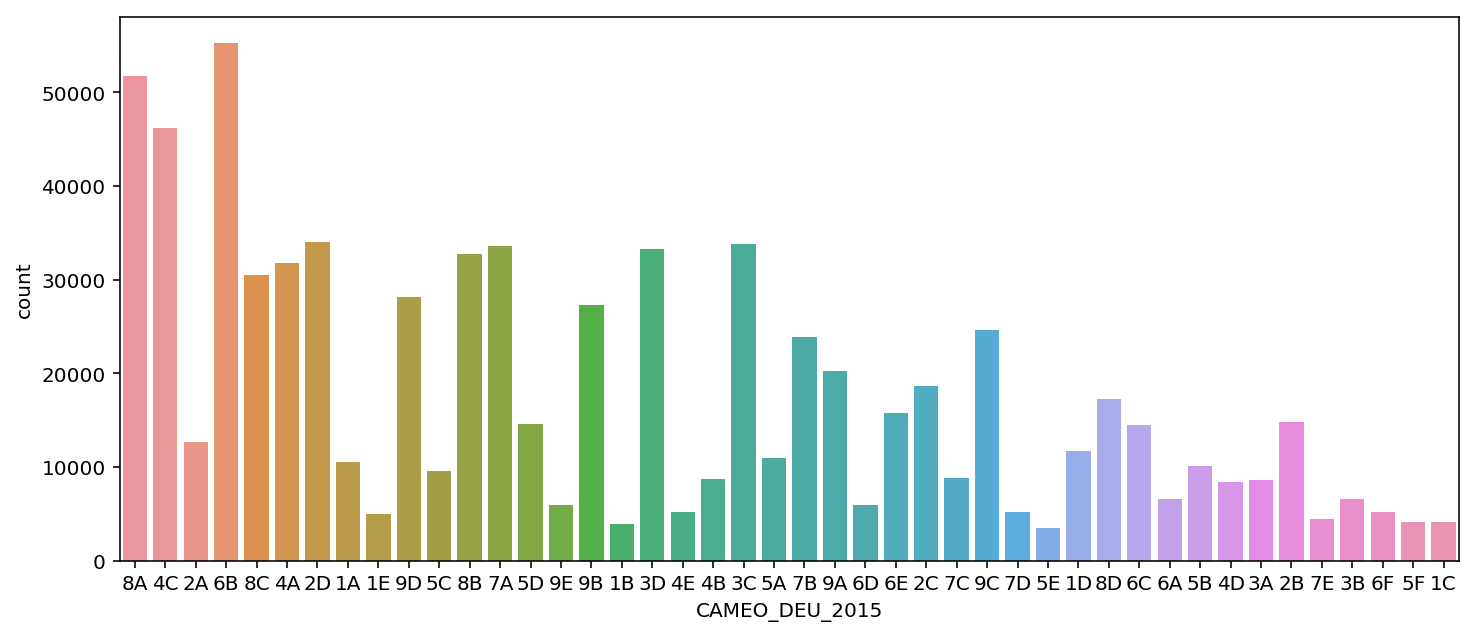

In [23]:
# The distribution of 'CAMEO_DEU_2015' data.
plt.figure(figsize = (12, 5))
sns.countplot(x= 'CAMEO_DEU_2015', data=df_nan_less)
plt.title('fig 1.10 The distribution of values for CAMEO_DEU_2015 column')
plt.show()

In [24]:
# drop 'CAMEO_DEU_2015' column
#df_nan_less_copy = df_nan_less.copy()
multi_level_categoricals_dict.pop('CAMEO_DEU_2015')
df_nan_less.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Re-encode binary categorical variables as numbers of 'OST_WEST_KZ'
replace_dic = {key: val for key, val in zip(binary_categoricals_dict['OST_WEST_KZ'], range(2))}

df_nan_less['OST_WEST_KZ'].replace(replace_dic, inplace=True)

**If I don't do a copy for `df_nan_less`, it will raise a warning “A value is trying to be set on a copy of a slice from a DataFrame”. I have read the documentation, but I still don't understand the logic of this warning. Could you tell me setting a value on a copy of DataFrame is good or bad? If it's bad, why do I have to perform a copy operation and then the warning disappears?**

In [26]:
# Do one hot encode for multi-level categoricals
for feature in multi_level_categoricals_dict.keys():
    df_nan_less = pd.concat([df_nan_less, pd.get_dummies(df_nan_less[feature], prefix=feature)], axis=1)
    df_nan_less.drop(feature, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
- There are 18 categorical features, 2 of which are binary (two-level) categoricals, others are multi-level categoricals.
- By looking at the data dictionary, I found that there are some columns that contain mappings.'LP_LEBENSPHASE_FEIN'->'LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN'->'LP_FAMILIE_GROB','LP_STATUS_FEIN'->'LP_STATUS_GROB'.The '..._GROB' columns are rough scale of '..._FEIN'. I think it's okay to keep the rough scale columns. This helps to reduce the number of final features, since some features are then encoded. So I dropped delete the '..._FEIN' columns.
Since I didn't know which features might be important, I kept all the data.
- The feature 'OST_WEST_KZ' takes on non-numeric values. I re-encode the values as 0 and 1.
- For multi-level categoricals, I encoded the values using multiple dummy variables.
- I have noticed that 'CAMEO_DEU_2015' datas has much more values than other categorical features. And the distribution of data is not particularly balanced. If I use OneHotEncoder to encode them, I will generate a lot of new columns, so I dropped this column.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# get the list of features with mixed_type data
mixed_features_list = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
# if the feature has been dropped, delete it from the list
for feature in mixed_features_list:
    if feature not in df_nan_less.columns:
        mixed_features_list.remove(feature)
print(mixed_features_list)

['LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# movement_dict 0:mainstream, 1:avantgarde
movement_dict = {1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0,
                 2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1}
# decade_dict 0:40s, 1:50s, 2:60s, 3:70s, 4:80s, 5:90s
decade_dict = {1:0, 2:0, 3:1, 4:1, 5:2, 6:2, 7:2, 8:3, 9:3,
               10:4, 11:4, 12:4, 13:4, 14:5, 15:5}
movement = []
decade = []
for line in df_nan_less['PRAEGENDE_JUGENDJAHRE']:
    if line == line:
        movement.append(movement_dict[int(line)])
        decade.append(movement_dict[int(line)])
    else:
        movement.append(np.NaN)
        decade.append(np.NaN)

df_nan_less['MOVEMENT'] = movement
df_nan_less['DECADE'] = decade
df_nan_less.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth_stage = []
life_stage = []
for line in df_nan_less['CAMEO_INTL_2015']:
    if line == line:
        wealth_stage.append(int(line[0]))
        life_stage.append(int(line[1]))
    else:
        wealth_stage.append(np.NaN)
        life_stage.append(np.NaN)
        
df_nan_less['WEALTH_STAGE'] = wealth_stage
df_nan_less['LIFE_STAGE'] = life_stage
df_nan_less.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
- For PRAEGENDE_JUGENDJAHRE, I created two new columns MOVEMENT and DECADE to capture the decade and movement dimensions respectively. In MOVEMENT column, 0 refers to mainstream, and 1 refers to avantgarde.
- For CAMEO_INTL_2015, I broke up the two-digit codes into two new ordinal integers and stored in WEALTH_STAGE and LIFE_STAGE respectively.
- Since the information of these two columns (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) has been converted to columns, I finally deleted them.
- After checking `Data_Dictionary.md`, I think LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB are a bit complicated, so just keep them.
- The feat_info table marks WOHNLAGE and PLZ8_BAUMAX columns as Mixed-Type. According to the explanation in the `Data_Dictionary.md`, WOHNLAGE is neighborhood quality, and PLZ8_BAUMAX is most common building type within the PLZ8 region. I don't think these columns contain mixed information, so keep them.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
df_nan_less.reset_index(drop=True, inplace=True)


In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
df_nan_less.info()
# I have deleted PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 before ：）

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771701 entries, 0 to 771700
Columns: 130 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(44), int64(23), uint8(63)
memory usage: 440.8 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # load feature summary file
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs
    missing_unknown_dict = get_dict(feat_info)
    df = set_nan(df, missing_unknown_dict)
    
    # remove selected columns and rows
    ## remove columns with too many missing values
    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(outlier_columns, axis=1, inplace=True)
    
    ## remove rows with too many missing values
    num_remaining_features = df.shape[1]
    num_nan_row = num_remaining_features - df.count(axis=1)
    df_copy = df[df.index.isin(num_nan_row[num_nan_row < 9].index)].copy()
    
    # select, re-encode, and engineer column values.
    ## drop some similar columns
    drop_list = ['LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
    df_copy.drop(drop_list, axis=1, inplace=True)
    ## Re-Encode Categorical Features
    ### Re-encode binary categorical variables as numbers of 'OST_WEST_KZ'
    binary_categoricals_dict = {'OST_WEST_KZ': ['W', 'O']}
    replace_dic = {key: val for key, val in zip(binary_categoricals_dict['OST_WEST_KZ'], range(2))}
    df_copy['OST_WEST_KZ'].replace(replace_dic, inplace=True)
    
    ### Do one-hot encode for multi-level categoricals
    df_copy.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    multi_level_categoricals_list = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
                                     'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                                     'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
    for feature in multi_level_categoricals_list:
        df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[feature], prefix=feature)], axis=1)
        df_copy.drop(feature, axis=1, inplace=True)
        df_copy.reset_index(drop=True, inplace=True)
    
    ## Engineer Mixed-Type Features
    ### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # movement_dict 0:mainstream, 1:avantgarde
    movement_dict = {1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0,
                     2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1}
    
    # decade_dict 0:40s, 1:50s, 2:60s, 3:70s, 4:80s, 5:90s
    decade_dict = {1:0, 2:0, 3:1, 4:1, 5:2, 6:2, 7:2, 8:3, 9:3,
                   10:4, 11:4, 12:4, 13:4, 14:5, 15:5}
    movement = []
    decade = []
    for line in df_copy['PRAEGENDE_JUGENDJAHRE']:
        if line == line:
            movement.append(movement_dict[int(line)])
            decade.append(movement_dict[int(line)])
        else:
            movement.append(np.NaN)
            decade.append(np.NaN)

    df_copy['MOVEMENT'] = movement
    df_copy['DECADE'] = decade
    df_copy.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    wealth_stage = []
    life_stage = []
    for line in df_copy['CAMEO_INTL_2015']:
        if line == line:
            wealth_stage.append(int(line[0]))
            life_stage.append(int(line[1]))
        else:
            wealth_stage.append(np.NaN)
            life_stage.append(np.NaN)
        
    df_copy['WEALTH_STAGE'] = wealth_stage
    df_copy['LIFE_STAGE'] = life_stage
    df_copy.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # reset index
    df_copy.reset_index(drop=True, inplace=True)
    
    # Return the cleaned dataframe.
    return df_copy
    
df = clean_data(azdias_copy)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771701 entries, 0 to 771700
Columns: 130 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(44), int64(23), uint8(63)
memory usage: 440.8 MB


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [34]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_nan = []
for feature in df.columns.values:
    count_nan = df[feature].isnull().sum()
    df_nan.append(count_nan)
    if count_nan > 0:
        print(count_nan)
print('max number of NaN for features:', max(df_nan))
p = max(df_nan) / df.shape[0]
print(p)

2483
32488
38107
32488
53736
5404
3021
48
22808
22808
22808
22808
22808
501
501
501
5
52343
22808
52343
5033
7224
7224
7224
7224
7224
7224
7224
3855
3772
3855
24329
24329
3339
3339
max number of NaN for features: 53736
0.0696331869468


In [35]:
# cleaned the dataset of all NaN values
num_remaining_features = df.shape[1]
num_nan_row = num_remaining_features - df.count(axis=1)
df = df[df.index.isin(num_nan_row[num_nan_row == 0].index)]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623210 entries, 0 to 771700
Columns: 130 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(44), int64(23), uint8(63)
memory usage: 360.8 MB


In [37]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
data = scaler.fit_transform(df)

### Discussion 2.1: Apply Feature Scaling

- The printed results show that there are still some NaN values in the data. The maximum number of NaN values in each column is 53736, accounting for 6.96% of the total number of rows. I am not sure if the criteria I used when filtering rows and columns are appropriate. 
- So far, I still tended to keep as many features as possible. So I deleted all the line containing the NaN value, then applied the scaler.
- I still have a little bit of confusion, is that feature scaling affects the one hot encoding? I think their value will no longer be 0 and 1, but I don't know if there is any further impact.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.
pca = PCA()
pca_data = pca.fit_transform(data)

In [39]:
# The plot function comes from the previous course
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

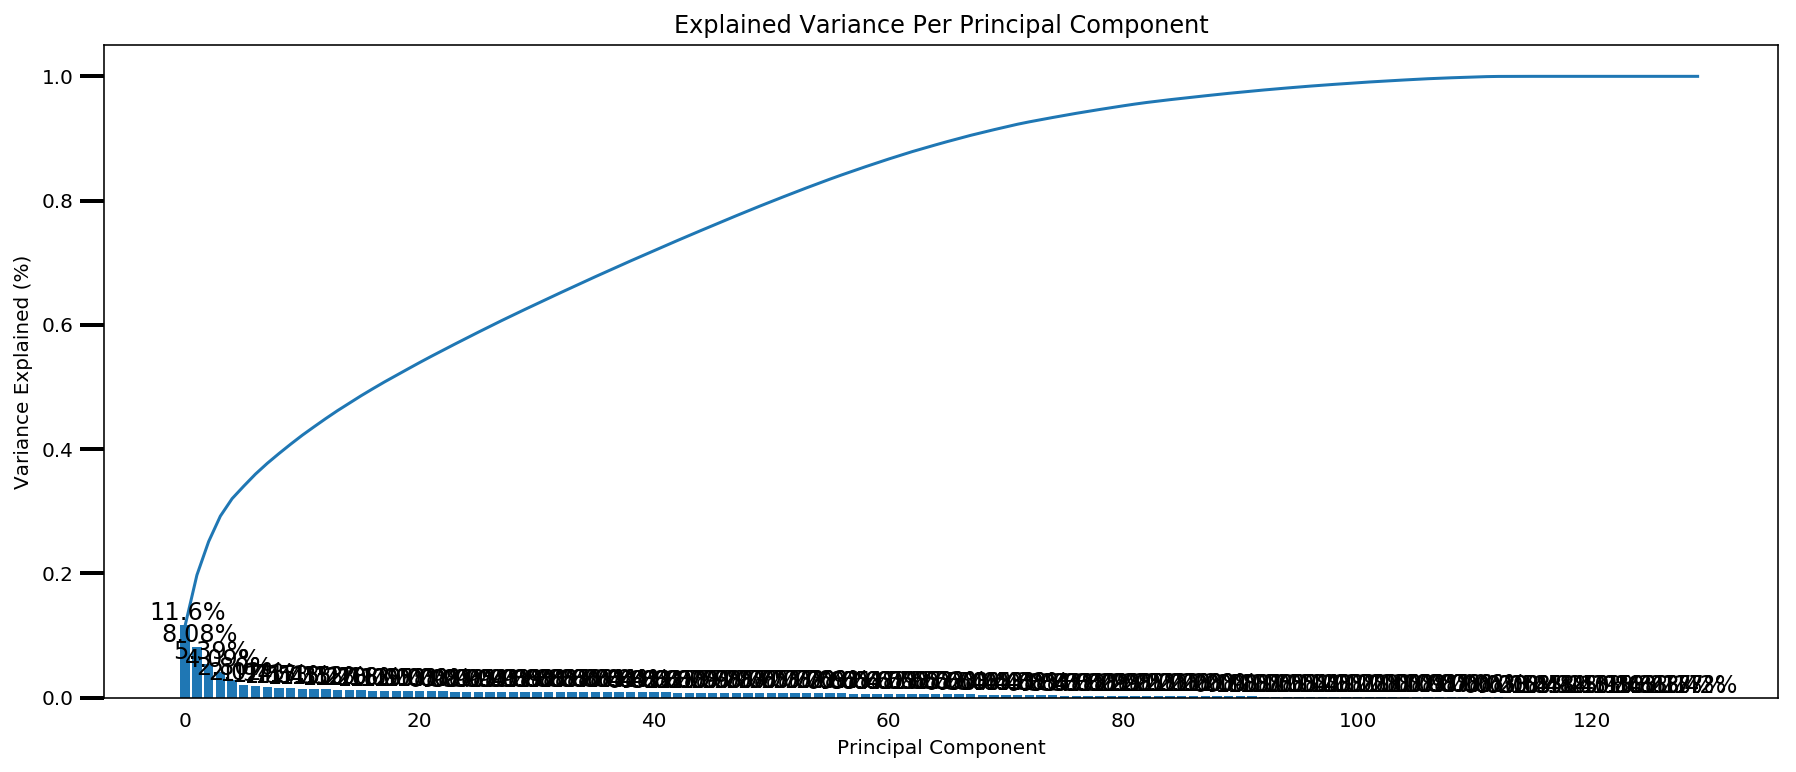

In [40]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

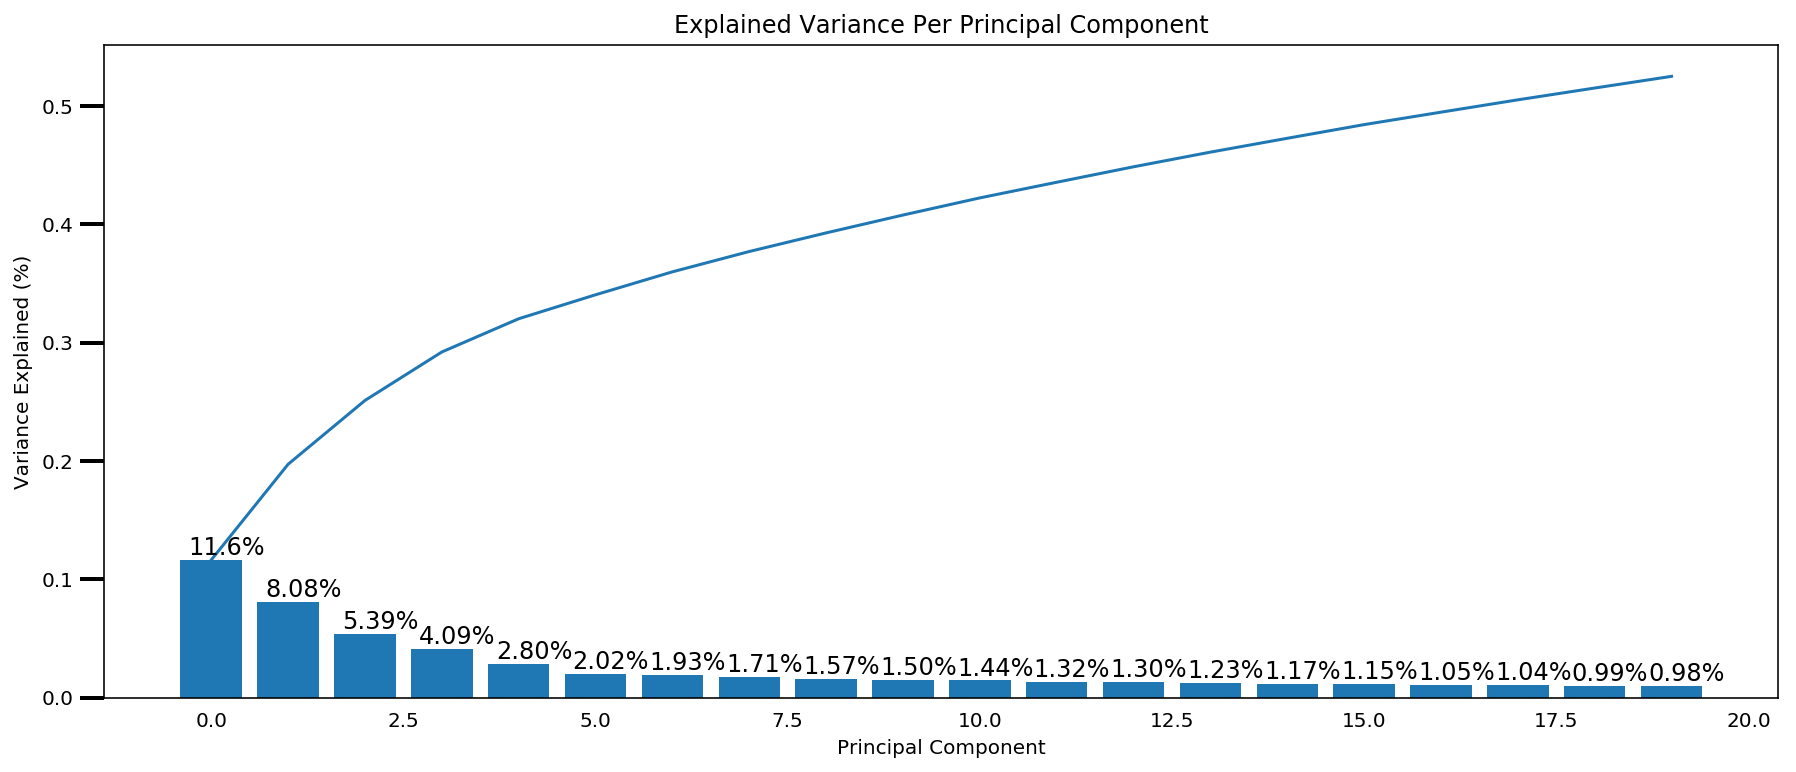

In [41]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=20)
pca_data = pca.fit_transform(data)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

- First, I didn't set any parameters (so all components are computed) to see the general trend in variability. Based on the cumulative variance explained, I think the principal components can be roughly divided into three parts. The cumulative variance growth rate of the 1st to the 20th principal components gradually decreases. The cumulative variance growth rate of the 20th to 100th principal components is relatively stable. The cumulative variance growth rate of the remaining principal components gradually decreases.
- The more the principal component is retained, the more information is retained, but the clustering is also more time consuming. I have tried to retain 20, 30, and 60 principal components, which can retain about 50%, 60%, and 80% variance explained, respectively. However, the time spent on Kmean calculations also increases, especially when the number of clusters is large.
- It is really difficult for me to choose the amount of principal components retention. Because of the need to balance the loss of information and the efficiency of clustering. And I don't know the quality of the clustering results for the time being. Finally, I retained 30 principal components. The cumulative variance explained is about 50%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [42]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(columns, pca, n):
    pc_map = pd.DataFrame({'0 attribute': columns, '1 weight': pca.components_[n-1],
                           '2 Absolute value of weight': np.abs(pca.components_[n-1])})    
    return pc_map.sort_values('2 Absolute value of weight', ascending=False)[:5]

In [43]:
pc1_map = map_weights(df.columns, pca, 1)
pc1_map

,0 attribute,1 weight,2 Absolute value of weight
49,MOBI_REGIO,-0.210150,0.210150
39,KBA05_ANTG1,-0.197737,0.197737
92,LP_STATUS_GROB_1.0,0.194877,0.194877
2,FINANZ_MINIMALIST,-0.194852,0.194852
53,PLZ8_ANTG1,-0.189718,0.189718


In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2_map = map_weights(df.columns, pca, 2)
pc2_map

,0 attribute,1 weight,2 Absolute value of weight
0,ALTERSKATEGORIE_GROB,0.242134,0.242134
14,SEMIO_REL,-0.240848,0.240848
3,FINANZ_SPARER,-0.222653,0.222653
24,SEMIO_PFLICHT,-0.222378,0.222378
25,SEMIO_TRADV,-0.218197,0.218197


In [45]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3_map = map_weights(df.columns, pca, 3)
pc3_map

,0 attribute,1 weight,2 Absolute value of weight
1,ANREDE_KZ,-0.338027,0.338027
16,SEMIO_VERT,0.319874,0.319874
23,SEMIO_KAEM,-0.307562,0.307562
22,SEMIO_DOM,-0.277831,0.277831
21,SEMIO_KRIT,-0.254242,0.254242


### Discussion 2.3: Interpret Principal Components

- For the first principal component, the most weighted feature is MOBI_REGIO, which represents the level of movement in the region. The second important feature isLP_STATUS_GROB_1.0, which represents the low-income earners.The third important feature is KBA05_ANTG1, which represents the proportion of small houses (1-2 family homes) in microcells. The weights of MOBI_REGIO and KBA05_ANTG1 are both negative, indicating that they are positively correlated. The higher the proportion of small houses in the microcell, the higher the level of movement. I speculate that this principal component mainly reflects information on building, neighborhood, social status, etc.
- For the second principal component, the most weighted feature is ALTERSKATEGORIE_GROB, which represents estimated age based on given name analysis（**I am curious how to estimate the age only by given name?** ）. The second important feature is SEMIO_REL, which represents one's affinity for religion. The third important feature is FINANZ_SPARER, indicate how much a person belongs to money-saver.I speculate that this principal component mainly reflects information such as age, gender, and economic status.
- For the third principal component, the most weighted feature is ANREDE_KZ, which represents the gender. The next few features are 'SEMIO_...', representing personality typology, such as dreamful, combative attitude, critical-minded and so on. From the sign of weight, it can be inferred that the character of dreamful is negatively related to combative and critical-minded. I speculate that this principal component mainly reflects the gender, personality characteristics and other information.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [46]:
# Over a number of different cluster counts...
score_list = []
for i in range(2, 20):
    start = time.time()
    # run k-means clustering on the data and...
    cluster = KMeans(n_clusters=i, random_state=0)
    model = cluster.fit(pca_data)
    
    # compute the average within-cluster distances.
    score = model.inertia_
    score_list.append(score)
    print('centers:', i, 'score:', score, 'fit time:{:.1f} seconds'.format(time.time()-start) )

centers: 2 score: 34603019.2581 fit time:10.6 seconds
centers: 3 score: 31321237.2445 fit time:22.3 seconds
centers: 4 score: 29236090.3171 fit time:23.0 seconds
centers: 5 score: 27644655.1385 fit time:25.1 seconds
centers: 6 score: 26463765.9513 fit time:40.2 seconds
centers: 7 score: 25460628.1425 fit time:51.6 seconds
centers: 8 score: 24672547.3718 fit time:75.5 seconds
centers: 9 score: 24127623.527 fit time:111.8 seconds
centers: 10 score: 23483156.5214 fit time:90.7 seconds
centers: 11 score: 23071386.5949 fit time:130.0 seconds
centers: 12 score: 22700878.8623 fit time:161.9 seconds
centers: 13 score: 22398034.4949 fit time:150.0 seconds
centers: 14 score: 22067853.3241 fit time:185.0 seconds
centers: 15 score: 21787634.6321 fit time:224.0 seconds
centers: 16 score: 21514944.2476 fit time:218.6 seconds
centers: 17 score: 21283754.481 fit time:249.0 seconds
centers: 18 score: 21004300.1724 fit time:256.6 seconds
centers: 19 score: 20778153.3206 fit time:371.5 seconds


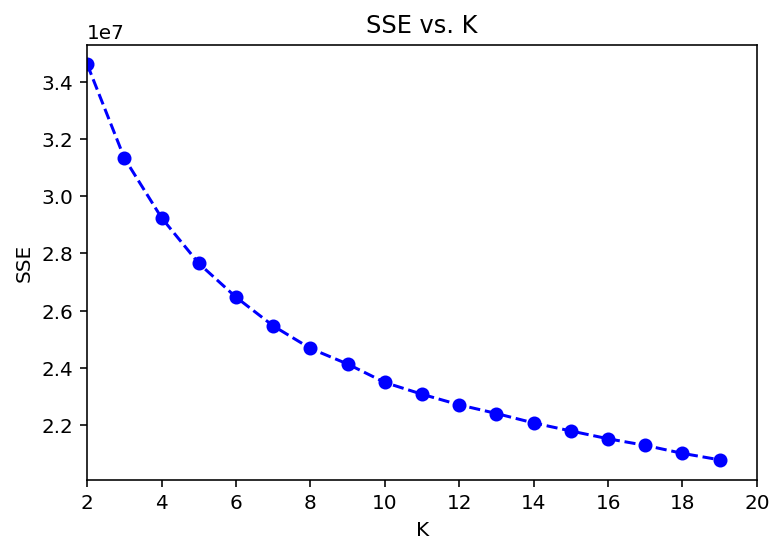

In [47]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(list(range(2,20)), score_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xlim(2,20)
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [92]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
cluster = KMeans(n_clusters=11, random_state=0)
predict = cluster.fit_predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population

- The score does not have a very obvious elbow point. When the number of clusters is greater than 11, the decrease in the average distance becomes relatively flat. So I set `n_clusters` to 11.
- In sklearn, the score is defined as the inverse of average difference from each point to its assigned cluster's center. Therefore, the higher the score, the better the clustering result.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [93]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [94]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# preprocessing
df_customers = clean_data(customers)
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135799 entries, 0 to 135798
Columns: 129 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(44), int64(23), uint8(62)
memory usage: 77.4 MB


**Note: The customers data is one column less than the demographic data. It may be caused by the one hot encoding. I have to find that column first.**

In [95]:
azdias_features = df.columns
custoomers_features = df_customers.columns
for feature in azdias_features:
    if feature not in custoomers_features:
        print(feature)

GEBAEUDETYP_5.0


In the case of one hot encoding, 'GEBAEUDETYP_5.0' column is not generated because the 'GEBAEUDETYP' column of the customer data does not have a value of 5.0. Add this column to the user data and fill it with 0.

In [96]:
df_customers['GEBAEUDETYP_5.0'] = [0 for _ in range(df_customers.shape[0])]

In [97]:
# check NaN
df_customer_nan = []
for feature in df_customers.columns.values:
    count_nan = df_customers[feature].isnull().sum()
    df_customer_nan.append(count_nan)
    if count_nan > 0:
        print(count_nan)
print('max number of NaN for features:', max(df_customer_nan))
p = max(df_customer_nan) / df_customers.shape[0]
print(p)

204
1933
5954
1933
7194
2090
1872
5
3669
3669
3669
3669
3671
27
27
27
8423
3669
8423
399
740
740
740
740
740
740
740
524
504
524
847
847
212
212
max number of NaN for features: 8423
0.0620254935603


In [98]:
# cleaned the dataset of all NaN values
num_remaining_features = df_customers.shape[1]
num_nan_row = num_remaining_features - df_customers.count(axis=1)
df_customers = df_customers[df_customers.index.isin(num_nan_row[num_nan_row == 0].index)]
# standarscaler
data_customers = scaler.transform(df_customers)
# PCA
pca_data_customers = pca.transform(data_customers)
# predict
customers_predict = cluster.predict(pca_data_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [99]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
num_pop = len(predict)
num_cus = len(customers_predict)
p_pop_list = []
p_cus_list = []
for c in range(11):
    p_pop_list.append(sum(predict == c) / num_pop)

for c in range(11):
    p_cus_list.append(sum(customers_predict == c) / num_cus)


<function matplotlib.pyplot.show>

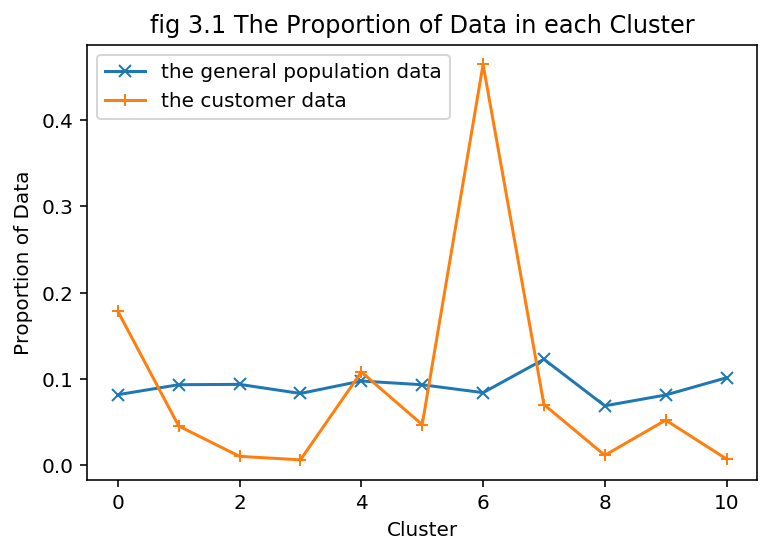

In [100]:
x = list(range(11))
plt.plot(x, p_pop_list, "x-", label="the general population data")
plt.plot(x, p_cus_list, "+-", label="the customer data")
plt.xlabel('Cluster')
plt.ylabel('Proportion of Data')
plt.title('fig 3.1 The Proportion of Data in each Cluster')
plt.legend()
plt.show

Text(0.5,1,'fig 3.3 The distribution of clusters for the customer data')

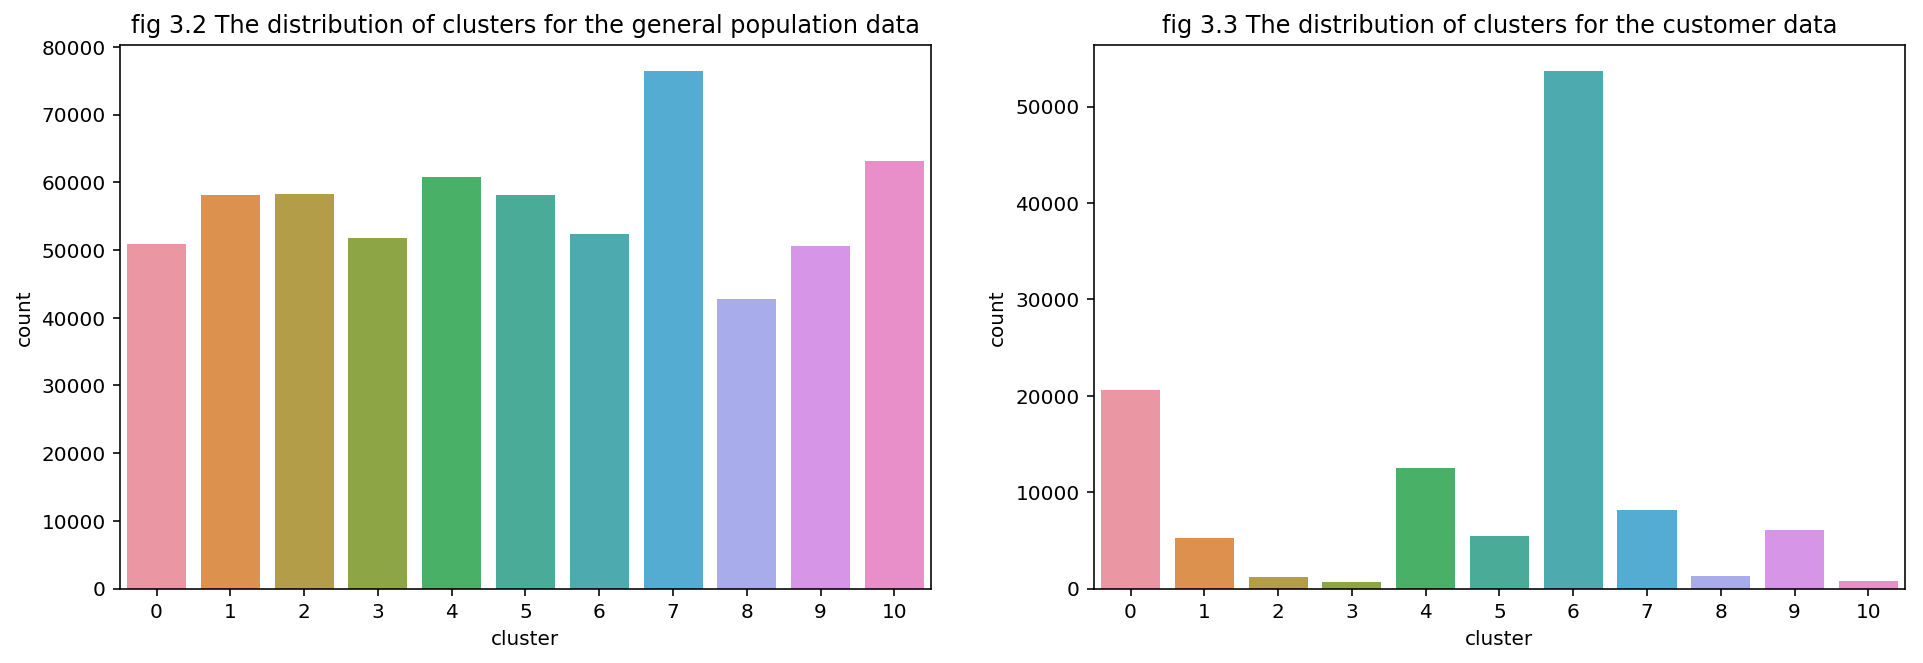

In [101]:
pop_predict_df = pd.DataFrame({'cluster':predict})
cus_predict_df = pd.DataFrame({'cluster':customers_predict})
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.countplot(x='cluster', data=pop_predict_df)
plt.title('fig 3.2 The distribution of clusters for the general population data')
plt.subplot(122)
sns.countplot(x='cluster', data=cus_predict_df)
plt.title('fig 3.3 The distribution of clusters for the customer data')

In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centers = cluster.cluster_centers_
pca_inverse = pca.inverse_transform(centers)
scale_inverse = scaler.inverse_transform(pca_inverse)
original_data_space = pd.DataFrame(scale_inverse, columns = df_customers.columns).round(0)


In [120]:
original_data_space.loc[[6]]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH_STAGE,LIFE_STAGE,GEBAEUDETYP_5.0
6,3.0,1.0,5.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0


In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
original_data_space.loc[[2]]


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH_STAGE,LIFE_STAGE,GEBAEUDETYP_5.0
2,2.0,2.0,2.0,4.0,2.0,4.0,4.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0


<function matplotlib.pyplot.show>

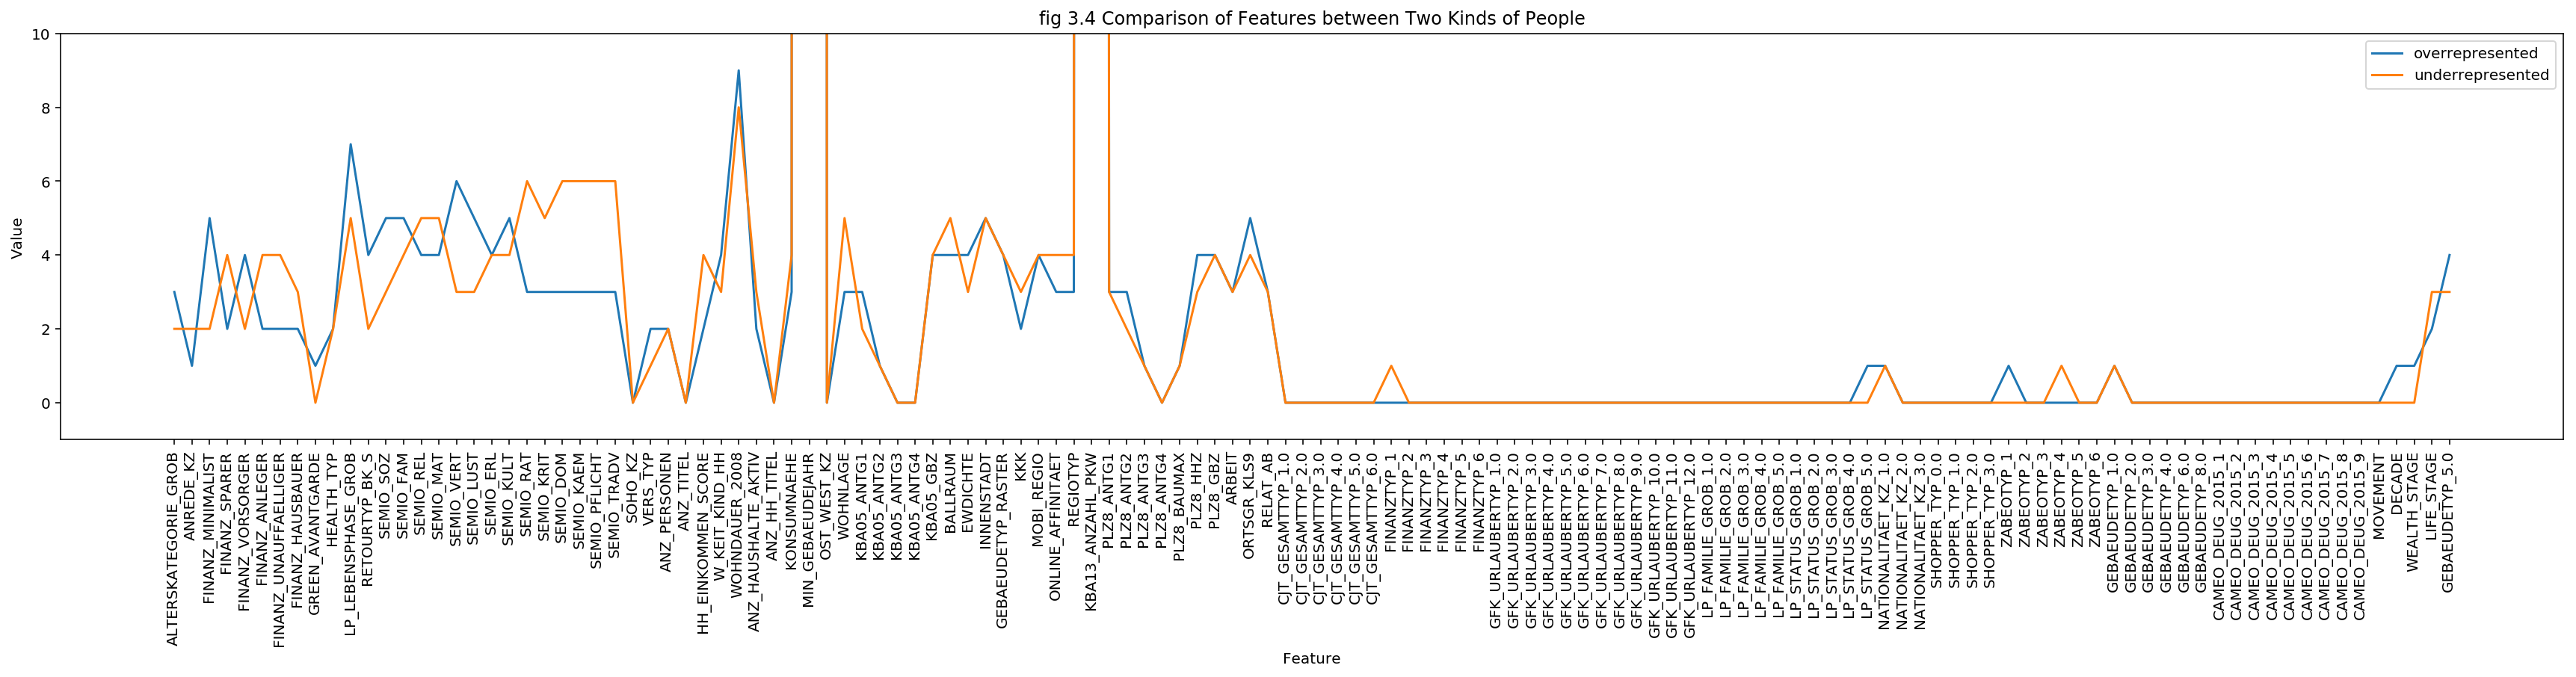

In [137]:
x = list(range(len(original_data_space.columns)))
overrepresented = np.array(original_data_space.iloc[6])
underrepresented = np.array(original_data_space.iloc[2])
plt.figure(figsize=(30,5))
plt.plot(x, overrepresented, label="overrepresented")
plt.plot(x, underrepresented, label="underrepresented")
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('fig 3.4 Comparison of Features between Two Kinds of People')
plt.ylim(-1,10)
plt.legend()
plt.xticks(x, original_data_space.columns, rotation=90)
plt.show

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
- From Figure 3.1, we can see that the distribution of general population data in each cluster is relatively balanced, and the distribution of customer data is quite different. The distribution of the two datasets can also be visually seen from Figures 3.2 and 3.3.
- By comparing the proportion, I think cluster 6 is overrepresented in the customer data compared to the general population, and cluster 2, 4, 10 are underrepresented.
- I decided to use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly. But in fact, the result of the transformation is not very satisfactory. I got a lot of outliers, such as numbers over 1000.
- Finally, for the sake of observation, I limited the range of the y-axis to -1 to 10, and plotted the feature values of the sixth and second cluster. In general, people with poor economic status and low social status are relatively popular with the mail-order company. Conversely, those with high incomes may not be the target users of the company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.